# Land use and land cover (LULC) change mapping with deep learning

We constructed the workflow into three steps:

- Step 1. Training data generation from multiple GeoTiffs we prepared using [eo-learn](https://eo-learn.readthedocs.io/en/latest/) package.

- Step 2. Training model on the cloud with fast.ai dynamic Unet. You can run the notebook on any cloud provider's GPU machines or run the [exact notebook on Google Colab](https://colab.research.google.com/drive/10Eup8QtXl1OzqjuuaduRHeFwOKQPkuX0).

- Step 3. Prediction and model inference over an unseen area.

The above steps were conceptionized from the current available eo-learn usecase in the [jupyter notebook](https://github.com/sentinel-hub/eo-learn/blob/master/examples/land-cover-fastai/deep_lulc_walkthrough.ipynb) and the [blog post](https://medium.com/@developmentseed/tracking-a-rapidly-changing-planet-bc02efe3545d).


**NOTE**: The fastai Python library is required to run this notebook, but is not part of the requirements of eo-learn. Make sure to install the library before running the notebook.

In [0]:
%matplotlib inline

import enum, glob, os
from os import path as op

from tqdm import tqdm_notebook as tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import numpy as np
import geopandas as gpd

from sentinelhub import BBoxSplitter
from eolearn.core import FeatureType, LinearWorkflow, EOTask, EOPatch
from eolearn.io import ImportFromTiff
from eolearn.geometry import VectorToRaster

# import computer vision from Fast.AI (+ pytorch)
from fastai.vision import *
import fastai.callbacks.hooks 
import fastai.utils.mem

import torch


In [0]:
# Have a look of our training and test dataset. 

root_dir = os.getcwd()
train_aoi_fname = op.join(root_dir, "small_train_aoi.geojson")
lulc_mask_fname = op.join(root_dir, "lulc_small_train.geojson")
slovenia_fname = op.join(root_dir, "svn_buffered.geojson")
test_aoi_fname = op.join(root_dir, "small_test_aoi.geojson")
target_crs = 'epsg:32633'

grid_sz = 168 # the image size to train our deep learning network

In [0]:
def aoi_grid(aoi, gr_sz):
    """
    read in shape file and reproject it into the projection that will compute correct aoi size
    
    Args:
        aoi: the AOI GeoDataFrame
        gr_sz: image size to split the AOI into
    Return:
        tiles: a numpy array of bounding boxes
    """
    # get the AOI geometry
    aoi_shape = aoi.geometry.tolist()[-1]
    
    # get the width and height of the area in pixels (sentinel-2 is in 10m resolution)
    s2_res = 10
    width_pix = int((aoi_shape.bounds[2] - aoi_shape.bounds[0]) / s2_res)
    heigth_pix = int((aoi_shape.bounds[3] - aoi_shape.bounds[1]) / s2_res)
    print('Dimension of the area is {} x {} pixels'.format(width_pix, heigth_pix))
    
    # get the number of grid cells wide and tall our area is
    grid_width = int(round(width_pix / gr_sz))
    grid_height = int(round(heigth_pix / gr_sz))

    # split the tile grid by the desired grid number
    tile_splitter = BBoxSplitter([aoi_shape], target_crs, (grid_width, grid_height))
    print("The area is split into a grid with {} by {} tiles".format(grid_width, grid_height))

    tiles = np.array(tile_splitter.get_bbox_list())
    return tiles

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


(357737.03586605104, 632593.8219180192, 5016135.9977509845, 5204957.806954052)

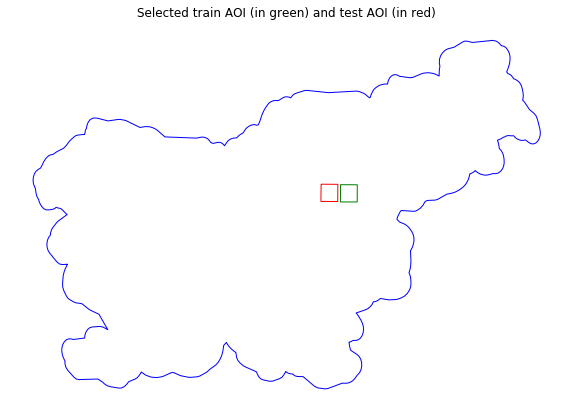

In [6]:
# Load geojson files
country = gpd.read_file(slovenia_fname)
train_polygon = gpd.read_file(train_aoi_fname)
test_polygon = gpd.read_file(test_aoi_fname)

# reproject the polygons 
country = country.to_crs(crs={'init': target_crs})
train_polygon = train_polygon.to_crs(crs={'init': target_crs})
test_polygon = test_polygon.to_crs(crs={'init': target_crs})

# plot
fig, ax = plt.subplots(figsize=(10, 10))
plot_settings = dict(ax=ax, facecolor='w')

country.plot(edgecolor='b', **plot_settings)
train_polygon.plot(edgecolor='g', **plot_settings) # train area in green
test_polygon.plot(edgecolor='r', **plot_settings) # test area in red

ax.set_title('Selected train AOI (in green) and test AOI (in red)');
plt.axis('off')

# Step 1. Training data generation

Creating and constructing training dataset that contain Sentinel-2 indices and lulc mask with eo-learn. 



In [0]:
class NormalizedDifferenceIndex(EOTask):
    """
    Defined Normalised Difference Index (NDI) between two bands A and B as:
    NDI = (A-B)/(A+B).
    """
    def __init__(self, feature_name, band_a, band_b):
        self.feature_name = feature_name
        self.band_a_feature_name = band_a.split('/')[0]
        self.band_b_feature_name = band_b.split('/')[0]
        self.band_a_feature_idx = int(band_a.split('/')[-1])
        self.band_b_feature_idx = int(band_b.split('/')[-1])

    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_feature_name][..., self.band_a_feature_idx].astype(np.int16)
        band_b = eopatch.data[self.band_b_feature_name][..., self.band_b_feature_idx].astype(np.int16)

        ndi = (band_a - band_b) / (band_a  + band_b + 1e-5)

        eopatch.add_feature(FeatureType.DATA, self.feature_name, ndi[..., np.newaxis])

        return eopatch

class ConcatenateData(EOTask):
    """Task to concatenate data arrays along the last dimension"""
    def __init__(self, feature_name, feature_names_to_concatenate):
        self.feature_name = feature_name
        self.feature_names_to_concatenate = feature_names_to_concatenate

    def execute(self, eopatch):
        arrays = [eopatch.data[name] for name in self.feature_names_to_concatenate]

        eopatch.add_feature(FeatureType.DATA, self.feature_name, np.concatenate(arrays, axis=-1))

        return eopatch

In [8]:
# task to read data directly from a GeoTIFF
add_data = ImportFromTiff((FeatureType.DATA, 'BANDS'))

# We only query Sentinel-2's Band 3, 4, 8 and 11 from SentinelHub.
# tasks for calculating indices
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NDBI: (B11 - B08)/(B11 + B08)

ndvi = NormalizedDifferenceIndex('NDVI', 'BANDS/2', 'BANDS/1')
ndwi = NormalizedDifferenceIndex('NDWI', 'BANDS/0', 'BANDS/2')
ndbi = NormalizedDifferenceIndex('NDBI', 'BANDS/3', 'BANDS/2')


# task for adding our index bands into one array
concatenate = ConcatenateData('FEATURES', ['NDVI', 'NDWI', 'NDBI'])


# task for adding the LULC mask
lulc_mask = gpd.read_file(lulc_mask_fname)
lulc_mask = lulc_mask.to_crs({'init': target_crs})

# rasterize the labeled land use and land cover polygons by their 'lulcid'.
land_cover_task_array = VectorToRaster(
    vector_input = lulc_mask,
    raster_feature = (FeatureType.MASK_TIMELESS, 'LULC'),
    values_column='lulcid',
    raster_shape=(FeatureType.DATA, 'BANDS'),
    raster_dtype=np.uint8)

# combine all tasks
workflow = LinearWorkflow(
    add_data,
    ndvi,
    ndwi,
    ndbi,
    concatenate,
    land_cover_task_array
)

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [9]:
# fetch the tile list from the input AOI for training
tile_list = aoi_grid(train_polygon, grid_sz)

# we have multiple geotiffs available to add into our patches
geotiffs = glob.glob(op.join(root_dir, 'merged_GTiffs/*.tif'))

print(f'{len(tile_list)} tiles', f'{len(geotiffs)} geotiffs')

Dimension of the area is 831 x 850 pixels
The area is split into a grid with 5 by 5 tiles
25 tiles 11 geotiffs


In [10]:
# iterate over all of our patches/tiles
training_data = []
pbar = tqdm(total=len(tile_list))
for idx, bbox in enumerate(tile_list):
    # create a separate patch for each geotiff
    for geotiff in geotiffs:
        patch = EOPatch()
        patch.bbox = bbox
        # define additional parameters of the workflow
        extra_param = {
            add_data: {'eopatch': patch, 'filename': geotiff}
        }

        training_data.append(workflow.execute(extra_param).eopatch())
        pbar.update(1)

In [11]:
training_data[0]

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(1, 171, 166, 4), dtype=uint16)
    FEATURES: numpy.ndarray(shape=(1, 171, 166, 3), dtype=float64)
    NDBI: numpy.ndarray(shape=(1, 171, 166, 1), dtype=float64)
    NDVI: numpy.ndarray(shape=(1, 171, 166, 1), dtype=float64)
    NDWI: numpy.ndarray(shape=(1, 171, 166, 1), dtype=float64)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LULC: numpy.ndarray(shape=(171, 166, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((521621.19460719347, 5116784.057630871), (523284.16113176994, 5118486.037840394)), crs=EPSG:32633)
  timestamp: []
)

# Step 2. Training model on the cloud

We recoomend you run the following model training on a GPU machine that with [fastai](https://github.com/fastai/fastai) installed. 

Since the current fastai package is built on top of pytorch, we need to convert our training dataset from numpy array to pytorch tensor before the model training.


In [0]:
class ArraySegmentationLabelList(SegmentationLabelList):
    def get(self, i):
        label = self.items[i].astype(np.uint8)
        return ImageSegment(torch.from_numpy(label).long())

class ArraySegmentationItemList(SegmentationItemList):
    _label_cls = ArraySegmentationLabelList
    def get(self, i):
        item = self.items[i][1].astype(np.float32)
        return Image(torch.from_numpy(item))

    @classmethod
    def from_array(cls, array):
        return cls(list(enumerate(array)))

    def label_from_array(self, array, label_cls=None, **kwargs):
        indices, _ = zip(*self.items)
        labels = array[indices,:,:,:]
        return self._label_from_list(labels, label_cls=label_cls, **kwargs)

In [0]:
# taking each image size by (166, 166, 3)
grid_sz = 166
x_lst = []
y_lst = []

# going through the patches and add indices, e.g. NDVI, NDWI and NDBI, we created as X, and lulc as Y.
for patch in training_data:
    x_lst.append(patch.data['FEATURES'][0, :grid_sz, :grid_sz, :])
    y_lst.append(patch.mask_timeless['LULC'][:grid_sz, :grid_sz, :])

In [15]:
# covert the data into numpy array
x = np.array(x_lst)
y = np.array(y_lst)
(x.shape, y.shape)

((275, 166, 166, 3), (275, 166, 166, 1))

In [16]:
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 8], dtype=uint8),
 array([ 137027, 1208735, 2436478, 2248235,  214225,   98923,    1947, 1232330]))

In [0]:
# regrouping classes 4 - Shrubland and 6 - Wetland to class 0- Others
for v in [4, 6]:
  y = np.where(y== v, 0, y)


In [19]:
class_num = len(np.unique(y))
class_num

6

In [20]:
# neural nets like continuous class numbers, replace class 8 with 4
y = np.where(y==8, 4, y)
class_num = len(np.unique(y))
class_num

6

In [21]:
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=uint8),
 array([ 353199, 1208735, 2436478, 2248235, 1232330,   98923]))

In [22]:
# lulc classes we have for the model training
classes=list(range(class_num))
classes

[0, 1, 2, 3, 4, 5]

In [0]:
def create_data():
    '''our data has channels as the fourth-dimension, fastai expects it as the second, ie. (n, c, x, y)'''
    data = (ArraySegmentationItemList.from_array(x.swapaxes(3, 1))
            .split_by_rand_pct(valid_pct=0.2, seed=19)
            .label_from_array(y.swapaxes(3, 1), classes=classes)
            .databunch(bs=4) # batch size
            .normalize()
            
           )
    return data
  
data = create_data()

In [24]:
data

ImageDataBunch;

Train: LabelList (220 items)
x: ArraySegmentationItemList
Image (3, 166, 166),Image (3, 166, 166),Image (3, 166, 166),Image (3, 166, 166),Image (3, 166, 166)
y: ArraySegmentationLabelList
ImageSegment (1, 166, 166),ImageSegment (1, 166, 166),ImageSegment (1, 166, 166),ImageSegment (1, 166, 166),ImageSegment (1, 166, 166)
Path: .;

Valid: LabelList (55 items)
x: ArraySegmentationItemList
Image (3, 166, 166),Image (3, 166, 166),Image (3, 166, 166),Image (3, 166, 166),Image (3, 166, 166)
y: ArraySegmentationLabelList
ImageSegment (1, 166, 166),ImageSegment (1, 166, 166),ImageSegment (1, 166, 166),ImageSegment (1, 166, 166),ImageSegment (1, 166, 166)
Path: .;

Test: None

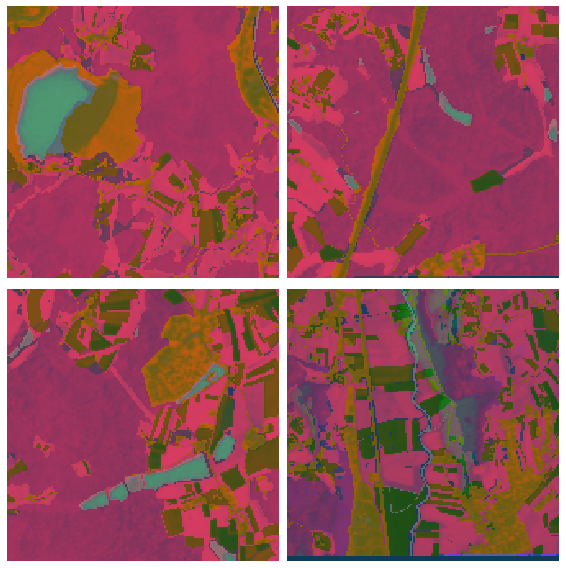

In [26]:
# show image bunch of labeled lulc with fastai
data.show_batch(rows = 2)

In [0]:
# we use focal loss as the loss function for the coming lulc training
class FocalLoss(nn.Module):
    ''' define the focal loss'''
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        one_hot = torch.zeros(targets.shape[0], class_num, targets.shape[2], targets.shape[3]).cuda()
        one_hot.scatter_(1, targets, 1)
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, one_hot.float(), reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean': return F_loss.mean()
        elif self.reduction == 'sum': return F_loss.sum()
        else: return F_loss

def pix_acc(input, target):
    ''' pixel accuray between true lulc label and predict lulc'''
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def class_acc(cl, input, target):
    '''to compute each lulc class's pixel accuracy'''
    target = target.squeeze(1)
    mask = target == cl
    score = (input.argmax(dim=1)[mask]==target[mask]).float().mean()
    return torch.tensor(np.nan_to_num(score))

# class number of lulc
class_num = len(np.unique(y))

# using partial to list the class accuracy for each lulc class during the model training
class_acc_metrics = [partial(class_acc, cl) for cl in range(class_num)]
for idx, metric in enumerate(class_acc_metrics):
    metric.__name__ = f'class_acc_{str(idx)}'  

In [0]:
# if you experience memory leak during the trainining uncomment the following lines to free up memory,
#learner.destroy()
#torch.cuda.empty_cache()

In [29]:
# the metrics for each model training epoch: overall pixel accuracy + lulc class accuracy
metrics = [pix_acc] + class_acc_metrics

# start model weight decay
WEIGHT_DECAY = 1e-2

# start model learning rate. We used fastai learning rate finder 'lr_finder' to search for this learning rate.
LEARNING_RATE = 1e-4

# using a pretrained resnet50 as the underline model to transfer learning our lulc model
learner = unet_learner(data, models.resnet50, metrics=metrics, wd=WEIGHT_DECAY)

# call focal loss 
learner.loss_func = FocalLoss()

# training 15 epoches 
learner.fit_one_cycle(10, slice(LEARNING_RATE), pct_start=0.8)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s]


epoch,train_loss,valid_loss,pix_acc,class_acc_0,class_acc_1,class_acc_2,class_acc_3,class_acc_4,class_acc_5,time
0,0.129783,0.093473,0.534262,0.059501,0.185505,0.739162,0.495758,0.557393,0.059200,02:15
1,0.096355,0.080281,0.616891,0.098954,0.303142,0.856090,0.608904,0.453711,0.197495,01:54
2,0.085410,0.077271,0.636243,0.107816,0.301584,0.878561,0.654277,0.448361,0.182147,01:54
3,0.077847,0.074147,0.667034,0.137526,0.248015,0.832567,0.817475,0.444019,0.357468,01:54
4,0.071893,0.080905,0.628294,0.150850,0.432914,0.623163,0.715622,0.631064,0.312337,01:54
5,0.067108,0.063263,0.714625,0.155840,0.340859,0.879592,0.820189,0.527091,0.307675,01:54
6,0.064245,0.063186,0.719418,0.155407,0.355876,0.952767,0.689397,0.647044,0.305044,01:54
7,0.059503,0.058975,0.729659,0.188080,0.388741,0.917520,0.841931,0.451417,0.307423,01:54
8,0.056732,0.056000,0.747990,0.188516,0.516225,0.925958,0.662008,0.765004,0.427607,01:54
9,0.051413,0.052537,0.765380,0.227492,0.437467,0.906538,0.790965,0.742816,0.372320,01:54


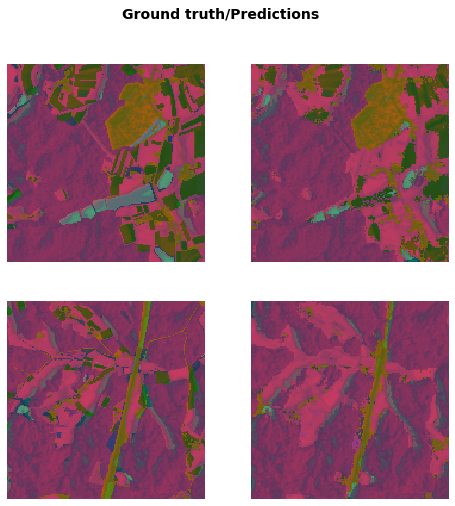

In [30]:
learner.show_results(rows = 2)

In [0]:
# get prediction
preds, y_true = learner.get_preds()
pred_class = preds.argmax(dim=1)

In [0]:
# flatten our tensors and use scikit-learn to create a confusion matrix
flat_preds = pred_class.reshape(grid_sz * grid_sz * len(data.valid_ds.x))
flat_truth = y_true.reshape(grid_sz * grid_sz * len(data.valid_ds.x))
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(class_num)))

(5.5, -0.5)

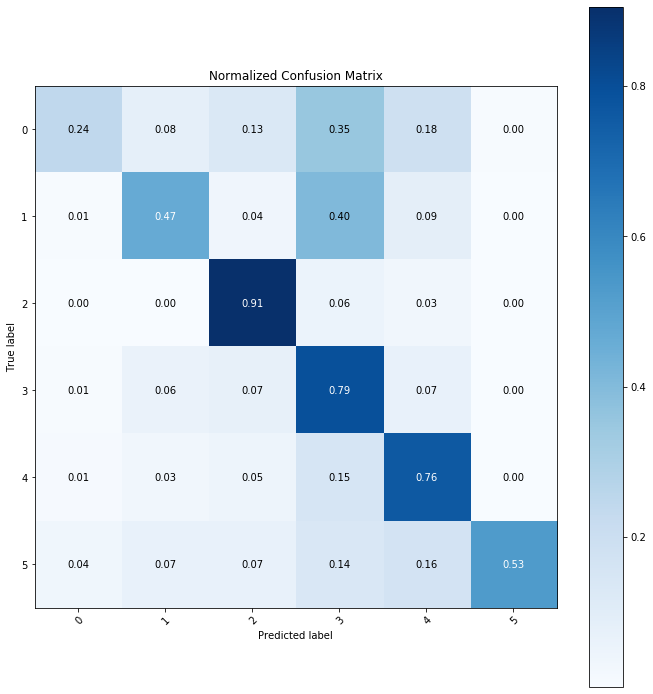

In [33]:
%matplotlib inline
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=list(range(class_num)), yticklabels=list(range(class_num)),
       title='Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)
ax.set_ylim(len(classes)-0.5, -0.5)

# Step 3. Prediction and model inference

In the following section, we will populate the test polygon we created with indices (NDVI, NDWI, NDBI) from Sentinel-2 Geotiffs. We will then run the model inference over the "unseen" area with the trained model from Senction 2.

In [34]:
# repeat the data prep on our test area
test_tile_list = aoi_grid(test_polygon, grid_sz)
workflow2 = LinearWorkflow(
        add_data,
        ndvi,
        ndwi,
        ndbi,
        concatenate)

Dimension of the area is 832 x 852 pixels
The area is split into a grid with 5 by 5 tiles


In [0]:
test_giff = op.join(root_dir, "merged_2017_6_20.tif")

In [36]:
test_data = []
pbar = tqdm(total=len(test_tile_list))
for bbox in test_tile_list:
    patch = EOPatch()
    patch.bbox = bbox
    # define additional parameters of the workflow
    extra_param = {
        add_data: {'eopatch': patch, 'filename': test_giff}
    }

    test_data.append(workflow2.execute(extra_param).eopatch())
    pbar.update(1)


In [37]:
test_data[0]

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(1, 171, 167, 4), dtype=uint16)
    FEATURES: numpy.ndarray(shape=(1, 171, 167, 3), dtype=float64)
    NDBI: numpy.ndarray(shape=(1, 171, 167, 1), dtype=float64)
    NDVI: numpy.ndarray(shape=(1, 171, 167, 1), dtype=float64)
    NDWI: numpy.ndarray(shape=(1, 171, 167, 1), dtype=float64)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((512021.33574899373, 5117011.489997711), (513686.8705882739, 5118716.029873956)), crs=EPSG:32633)
  timestamp: []
)

In [0]:
class LULC(enum.Enum):
    OTHERS             = (0,  'Others',            'grey')
    CULTIVATED_LAND    = (1,  'Cultivated Land',    'xkcd:lime')
    FOREST             = (2,  'Forest',             'xkcd:darkgreen')
    GRASSLAND          = (3,  'Grassland',          'orange')
    ARTIFICIAL_SURFACE = (4,  'Artificial Surface',  'crimson')
    WATER              = (5,  'Water',              'xkcd:azure')
    
    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3   

        
# Reference colormap things
lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])
lulc_norm = mpl.colors.BoundaryNorm(np.arange(-0.5, 6, 1), 7)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 720x720 with 0 Axes>

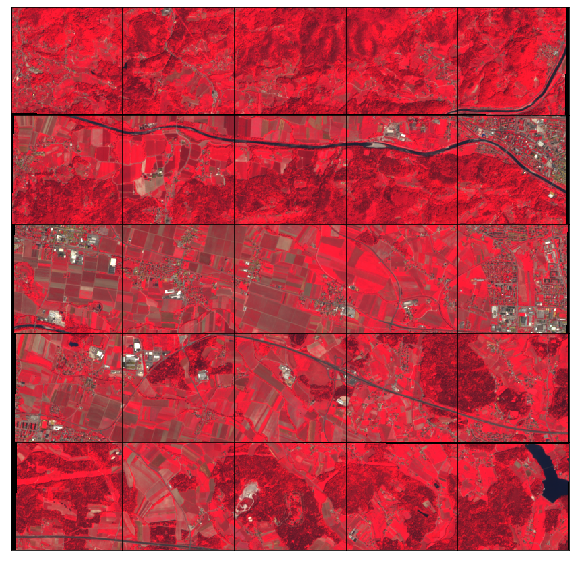

In [44]:
# result visulization
# Draw the RGB image

fig = plt.figure(figsize=(10, 10))

# Eopatch ID order from top left to bottom right.
# Draw the prediction images
fig, axes = plt.subplots(figsize=(10, 10), nrows=5, ncols=5)


for i, ax in enumerate(axes.transpose().flatten()):
    bands = test_data[i].data['BANDS'][0,..., [2, 1, 0]]
    bands = np.moveaxis(bands, 0, 2)
    im = ax.imshow(bands / 4000)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")

fig.subplots_adjust(wspace=0, hspace=0)

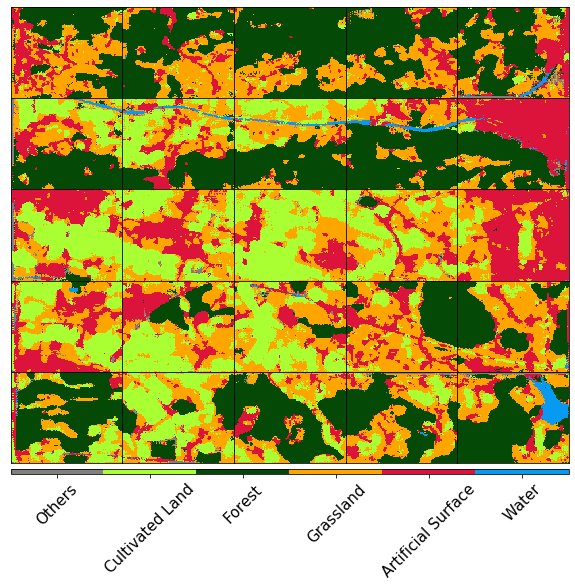

In [55]:
# Draw the prediction images
fig, axes = plt.subplots(figsize=(10, 10), nrows=5, ncols=5)

for j, ax in enumerate(axes.transpose().flatten()):
  img_arr = np.array(test_data[j].data['FEATURES'][0])
  img_arr_rsh = img_arr[:grid_sz, :grid_sz, :]
  img_arr_rsh = np.moveaxis(img_arr_rsh, -1, 0)
  img = Image(torch.from_numpy(img_arr_rsh).float())
  preds = learner.predict(img)[1]
  preds = np.squeeze(preds)
  preds = np.expand_dims(np.array(preds), 2) 
  test_data[j].add_feature(FeatureType.MASK_TIMELESS, "prediction", preds)
  im = ax.imshow(np.squeeze(preds), cmap=lulc_cmap, norm=lulc_norm)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_aspect("auto")


fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
cb.set_ticks([entry.id for entry in LULC])
cb.ax.set_xticklabels([entry.class_name for entry in LULC], rotation=45, fontsize=15)
plt.show()